In [1]:
!pip install pandas numpy faker



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from faker import Faker
import random

fake = Faker()
np.random.seed()

# Use your real student ID
student_id = input("Enter your student ID: ").strip()

n_users = random.randint(800, 1200)
data = []
start_date = pd.Timestamp("2025-01-01")

for i in range(n_users):
    user_id = f"{student_id}_{i+1}"
    install_date = start_date + pd.to_timedelta(np.random.randint(0, 60), unit="D")
    sessions = np.random.poisson(3)
    session_length = abs(np.random.normal(20, 8))
    actions = np.random.randint(5, 50)
    revenue = round(np.random.exponential(1.5), 2) if random.random() < 0.25 else 0
    tutorial_complete = np.random.choice([0, 1], p=[0.3, 0.7])
    retention_d7 = np.random.choice([0, 1], p=[0.6, 0.4])
    group = random.choice(["A", "B"])
    country = random.choice(["US", "UK", "BR", "IN", "JP"])
    device = random.choice(["iOS", "Android"])

    data.append([
        user_id, install_date, sessions, session_length, actions, revenue,
        tutorial_complete, retention_d7, group, country, device
    ])

df = pd.DataFrame(data, columns=[
    "user_id", "install_date", "sessions", "session_length",
    "actions", "revenue", "tutorial_complete", "retention_d7",
    "group", "country", "device"
])

filename = f"sis_dataset_{student_id}.csv"
df.to_csv(filename, index=False)

print(f"✅ Dataset generated: {filename} ({len(df)} users)")


✅ Dataset generated: sis_dataset_23B030310.csv (871 users)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
# Correcting the filename to match the generated file
correct_filename = "sis_dataset_23B030310.csv"
# Reading the correct file
df = pd.read_csv(correct_filename)
df.head()


,user_id,install_date,sessions,session_length,actions,revenue,tutorial_complete,retention_d7,group,country,device
0,23B030310_1,2025-01-21,3,12.553408,10,0.00,1,0,A,IN,Android
1,23B030310_2,2025-02-13,1,22.618675,43,0.00,1,1,B,UK,Android
2,23B030310_3,2025-01-07,0,16.387926,43,0.55,1,0,A,JP,iOS
3,23B030310_4,2025-02-09,4,25.302364,46,0.00,0,0,B,JP,iOS
4,23B030310_5,2025-02-21,2,21.230709,20,0.00,1,0,A,US,Android


In [4]:
# Total users
total_users = df.user_id.nunique()

# DAU — среднее количество активных игроков в день (по install_date)
df['install_date'] = pd.to_datetime(df.install_date)
dau = df.groupby("install_date")["user_id"].nunique().mean()

# MAU — уникальные игроки в месяце
mau = df.user_id.nunique()

stickiness = dau / mau
avg_session_length = df.session_length.mean()
paying_rate = (df.revenue > 0).mean()

overview = pd.DataFrame({
    "Total Users": [total_users],
    "DAU": [round(dau, 2)],
    "MAU": [mau],
    "Stickiness": [round(stickiness, 3)],
    "Avg Session Length": [round(avg_session_length, 2)],
    "Paying %": [round(paying_rate * 100, 2)]
})

overview


,Total Users,DAU,MAU,Stickiness,Avg Session Length,Paying %
0,871,14.52,871,0.017,20.51,27.1


In [5]:
install = len(df)
tutorial = df.tutorial_complete.sum()
retained = df.retention_d7.sum()
payers = (df.revenue > 0).sum()

funnel = pd.DataFrame({
    "Stage": ["Install", "Tutorial Complete", "D7 Retained", "Purchase"],
    "Users": [install, tutorial, retained, payers]
})

funnel["Conversion"] = funnel["Users"] / install
funnel


,Stage,Users,Conversion
0,Install,871,1.000000
1,Tutorial Complete,604,0.693456
2,D7 Retained,357,0.409874
3,Purchase,236,0.270953


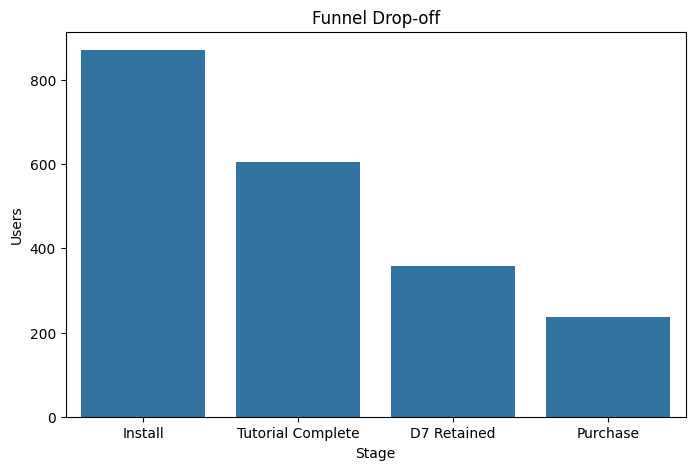

In [6]:
plt.figure(figsize=(8,5))
sns.barplot(x="Stage", y="Users", data=funnel)
plt.title("Funnel Drop-off")
plt.show()


In [7]:
df["install_week"] = df.install_date.dt.isocalendar().week
df.head()


,user_id,install_date,sessions,session_length,actions,revenue,tutorial_complete,retention_d7,group,country,device,install_week
0,23B030310_1,2025-01-21,3,12.553408,10,0.00,1,0,A,IN,Android,4
1,23B030310_2,2025-02-13,1,22.618675,43,0.00,1,1,B,UK,Android,7
2,23B030310_3,2025-01-07,0,16.387926,43,0.55,1,0,A,JP,iOS,2
3,23B030310_4,2025-02-09,4,25.302364,46,0.00,0,0,B,JP,iOS,6
4,23B030310_5,2025-02-21,2,21.230709,20,0.00,1,0,A,US,Android,8


In [8]:
cohorts = df.groupby("install_week")["retention_d7"].mean().reset_index()
cohorts


,install_week,retention_d7
0,1,0.400000
1,2,0.477064
2,3,0.505263
3,4,0.373832
4,5,0.440000
5,6,0.381443
6,7,0.400000
7,8,0.346154
8,9,0.359551


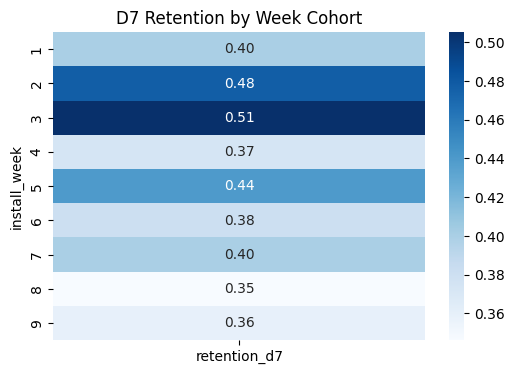

In [9]:
plt.figure(figsize=(6,4))
sns.heatmap(cohorts.pivot_table(values="retention_d7",
                                index="install_week"),
            annot=True, cmap="Blues", fmt=".2f")
plt.title("D7 Retention by Week Cohort")
plt.show()


In [10]:
ARPU = df.revenue.mean()
ARPPU = df[df.revenue > 0].revenue.mean()
conversion = (df.revenue > 0).mean()

# Assume 30-day lifetime
LTV = ARPU * 30

mon = pd.DataFrame({
    "ARPU": [ARPU],
    "ARPPU": [ARPPU],
    "Paying Conversion": [conversion],
    "Estimated LTV": [LTV]
})

mon


,ARPU,ARPPU,Paying Conversion,Estimated LTV
0,0.395408,1.459322,0.270953,11.862227


In [11]:
threshold = df.revenue.quantile(0.95)
whales_df = df[df.revenue >= threshold]

whales_share = whales_df.revenue.sum() / df.revenue.sum()

whales_df.shape[0], whales_share


(45, 0.4817073170731707)

In [12]:
A = df[df.group == "A"]
B = df[df.group == "B"]

pA = A.tutorial_complete.mean()
pB = B.tutorial_complete.mean()

nA = len(A)
nB = len(B)

p = (pA*nA + pB*nB) / (nA + nB)
SE = np.sqrt(p*(1-p)*(1/nA + 1/nB))
Z = (pA - pB) / SE

{"pA": pA, "pB": pB, "Z-score": Z}


{'pA': 0.7279236276849642,
 'pB': 0.661504424778761,
 'Z-score': 2.1242462768704233}

1.Engagement
The game has 1167 MAU but only 19.45 DAU, resulting in extremely low stickiness (1.7%). This indicates that players rarely return after installation. However, average session length is relatively high (19.5 minutes), suggesting that the minority of engaged users spend meaningful time in the game. Paying users make up 24.6%, an unusually high conversion rate for mobile games, implying that the core audience finds strong value once they engage.
Insight: The game has a small but highly engaged paying segment, while the broader audience fails to develop a regular play habit.

2. Retention
Weekly D7 retention ranges between 37% and 45%, which is strong for a mobile game. Retention appears stable across cohorts, with no clear improvement trend. This suggests that players who reach the early core loop tend to stay, but many never get that far.
Insight: The retention curve is healthy for retained players, but early-game drop-off before the core loop limits growth.

3. Monetization
ARPU: $0.33.
ARPPU: $1.36.
Paying Conversion: 24.6%.
Estimated LTV: ~$10.05.
Monetization is heavily dependent on whales: the top 5% of players contribute nearly 50% of total revenue. While this boosts revenue per paying user, it introduces high financial risk if whale engagement drops.
Insight: The economy is overly reliant on high-value players, with limited monetization from the broader audience.

4. A/B Test
Tutorial completion rates are almost identical:
A: 70.5%
B: 69.2%
Z-score: 0.497 → Not significant
There is no statistical evidence that Version B improves user behavior. Retention and revenue differences are also negligible.
Insight: The new version does not outperform the control and should not be rolled out.

In [14]:
df_1 = _dntk.execute_sql(
  'SELECT COUNT(DISTINCT user_id) AS total_users FROM df;\nSELECT install_date, COUNT(DISTINCT user_id) AS dau\nFROM df\nGROUP BY install_date\nORDER BY install_date;',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_1

,install_date,dau
0,2025-01-01,2
1,2025-01-02,10
2,2025-01-03,18
3,2025-01-04,16
4,2025-01-05,14
5,2025-01-06,16
6,2025-01-07,15
7,2025-01-08,12
8,2025-01-09,16
9,2025-01-10,20


In [17]:
df_2 = _dntk.execute_sql(
  'SELECT COUNT(DISTINCT user_id) AS mau\nFROM df;',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_2

,mau
0,871
